# 1 Making the reference catalogues

We need a photometric and astrometric reference. We are going to take the HSC PanSTARRS reference as a base and cross match in the VIDEO JHKs fluxes from the VHS DR6 release. 

The final astrometric reference catalogue will be GAIA DR2 astrometry. The photometric calibrators are yet to be determined since PanSTARRS does not cover the southern hemisphere.

After this has been done these reference catalogues must be ingested according to the instructions given in the DMU2 readme. This is a new procedure in gen 3.

In [1]:
from lsst.meas.algorithms.htmIndexer import HtmIndexer
from lsst.geom import SpherePoint 
from lsst.geom import degrees
from lsst.afw.image import abMagErrFromFluxErr, abMagFromFlux

import numpy as np
from astropy.io import fits
import astropy.units as u
from astropy.table import Table, vstack
import matplotlib.pyplot as plt
import glob
from collections import OrderedDict

from os.path import exists

In [2]:
ORIG = ''
PS_CATS = "../dmu0/dmu0_PanStarrs/data/ps1_pv3_3pi_20170110/"
PS_CATS19 = "../dmu0/dmu0_PanStarrs/data/ps1_pv3_3pi_20170110_GmagLT19/"
EX_CAT = "../dmu0/dmu0_PanStarrs/data/ps1_pv3_3pi_20170110/188416.fits"
EX_MS = "../dmu0/dmu0_PanStarrs/data/ps1_pv3_3pi_20170110/master_schema.fits"
MASS_CAT = '../dmu0/dmu0_2MASS/data/fp_2mass.fp_psc_29182.tbl'

VHS_CAT = '../dmu0/dmu0_VISTA/dmu0_VHS/data/VHS_DR6_XMM-HSCW02_XMM.fits.gz'

#PDR2
#VHS_CATS = glob.glob('../dmu0/dmu0_VISTA/dmu0_VHS/data/VHS_DR6_*.fits.gz')
#PDR3
VHS_CATS = glob.glob('../dmu0/dmu0_VISTA/dmu0_VHS/data/VHS_DR6_HSCPDR3*.fits.gz')

In [3]:
VHS_CATS

['../dmu0/dmu0_VISTA/dmu0_VHS/data/VHS_DR6_HSCPDR3_Spring.fits.gz',
 '../dmu0/dmu0_VISTA/dmu0_VHS/data/VHS_DR6_HSCPDR3_Autumn.fits.gz']

In [4]:
t = Table.read(EX_CAT)

In [5]:
t[:5]

id,coord_ra,coord_dec,parent,g_flux,r_flux,i_flux,z_flux,y_flux,i_fluxSigma,y_fluxSigma,r_fluxSigma,z_fluxSigma,g_fluxSigma,coord_ra_err,coord_dec_err,epoch,pm_ra,pm_dec,pm_ra_err,pm_dec_err,footprint
,rad,rad,,,,,,,,,,,,,,,,,,,
int64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float32,float32,int64,float32,float32,float32,float32,int32
108003593617180435,6.27204837905269,-1.7810517259552775e-06,0,9.550021786708385e-07,5.0367061703582294e-06,1.1320298654027283e-05,1.6851623513503e-05,2.1093712348374538e-05,5.097311941426597e-07,6.661442739641643e-07,3.404337576284888e-07,1.01842397270957e-06,1.2752344673572225e-06,0.0,0.0,1350001664,0.045981944,-0.043275457,0.034188043,0.034992907,0
107243599285956015,6.281939567078114,-0.01097539115627658,0,2.168949549741228e-06,4.778848506248323e-06,7.449491931765806e-06,1.3767468772130087e-05,1.9005747162736952e-05,3.657194724837609e-07,2.878014811358298e-06,2.7497526389197446e-07,1.5068798120410065e-06,3.1472012551603257e-07,0.0,0.0,1343807360,-0.06615359,-0.07740473,0.045893095,0.043096416,0
107233599379614290,6.282102758441709,-0.011144414345660884,0,2.3593809146404965e-06,1.6378801319660852e-06,2.9821883344993694e-06,6.162106274132384e-06,1.3584878615802154e-05,3.17906142299762e-07,2.2089609501563245e-06,3.794208396357135e-07,1.0178830507356906e-06,6.186981522660062e-07,0.0,0.0,1350889856,0.0,0.0,0.0,0.0,0
107223599413767784,6.282162404896845,-0.011239285087807067,0,3.910203759005526e-06,2.1229448066151235e-06,3.786871047850582e-06,5.439698270492954e-06,1.0658537576091476e-05,3.724599366705661e-07,2.33082960221509e-06,2.8468625146160775e-07,8.323602855853096e-07,1.7325971839454724e-06,0.0,0.0,1349434880,0.0,0.0,0.0,0.0,0
107223599465252718,6.2822490248996266,-0.011310071884075951,0,1.2273228549020132e-06,2.072620645776624e-06,2.9194793569331523e-06,5.422667072707554e-06,9.84519374469528e-06,4.909048243462166e-07,4.1293610593129415e-06,2.2009579936366208e-07,8.837623681756668e-07,3.434489599385415e-07,0.0,0.0,1330325888,0.0,0.0,0.0,0.0,0


In [6]:
def getShards(ra, dec, radius=1.):
    """Take a region defined by four corners and return shard ids
    
    We want every shard id in the region and for now do not 
    mind about having some ids on the boundary that are not in the region
    
    """
    ra_max = np.max(ra)
    ra_min = np.min(ra)
    dec_max = np.max(dec)
    dec_min = np.min(dec)
    
    htm = HtmIndexer(depth=7)
    all_shards = set()
    for radec in np.nditer(np.meshgrid(
        np.linspace(ra_min,ra_max,   num = int(np.ceil((ra_max-ra_min)/radius))),
        np.linspace(dec_min,dec_max, num = int(np.ceil((ra_max-ra_min)/radius)))
    )):
        
        shards, onBoundary = htm.getShardIds(SpherePoint(radec[0]*degrees, radec[1]*degrees), radius*degrees)
        all_shards = all_shards.union(set(shards))
    return all_shards
ps_refcats = getShards([27.,41.],  [-9,3])
' '.join([str(l) for l in list(ps_refcats)])

'133136 133137 133138 133139 133140 133141 133142 133143 133144 133145 133146 133147 133148 133149 133150 133151 133152 133153 133154 133155 133157 133158 133159 133160 133161 133162 133163 133164 133165 133166 133167 133168 133169 133170 133171 133173 133174 133175 133176 133177 133178 133179 133180 133181 133182 133183 133184 133185 133186 133187 133188 133189 133190 133191 133192 133193 133194 133195 133196 133197 133198 133199 133200 133201 133202 133203 133204 133205 133206 133207 133208 133209 133210 133211 133212 133213 133214 133215 133216 133217 133218 133219 133220 133221 133222 133223 133224 133225 133226 133227 133228 133229 133230 133231 133232 133233 133234 133235 133236 133237 133238 133239 133240 133241 133242 133243 133244 133245 133246 133247 133252 133253 133254 133255 133256 133257 133258 133259 133260 133261 133263 133264 133265 133266 133267 133268 133269 133270 133271 133272 133273 133274 133275 133276 133277 133278 133279 133280 133281 133282 133283 133284 13328

In [7]:
shards_wide = set()
for f in VHS_CATS:
    t = Table.read(f)['RA', 'DEC']
    t['RA'].unit = u.rad
    t['DEC'].unit = u.rad
    t['RA'].convert_unit_to(u.deg)
    t['DEC'].convert_unit_to(u.deg)
    shards_wide = shards_wide.union(getShards(t['RA'],t['DEC']))
    
print(len(ps_refcats), len(shards_wide))

907 18836


In [8]:
ps_refcats = shards_wide

In [9]:
len(ps_refcats)

18836

In [10]:
#SCP to download everything you need for the VHS/HSC Wide overlap - this breaks most shells
# files = ''
# for c in ps_refcats:
#     files += '{}.fits,'.format(c)
# print('scp ir-shir1@login.hpc.cam.ac.uk:~/rds/rds-iris-ip005/ras81/lsst-ir-fusion/dmu0/dmu0_PanSTARRS/data/ps1_pv3_3pi_20170110/{'
#       +files[:-1]+'} ./')

In [11]:
#CP to download everything you need for the VHS/HSC Wide overlap
files = ''
for c in ps_refcats:
    files += '{}.fits,'.format(c)
with open('../dmu0/dmu0_PanSTARRS/copy_vhs_hsc.sh', 'w') as the_file:
    the_file.write('#!/bin/bash\n')
    the_file.write('# This copies only the shards required to make the VHS/HSC refcats\n')
    the_file.write('mkdir -p ./data/vhs_hsc_subset_ps1_pv3_3pi_20170110/\n')
    the_file.write('cp -n ./data/ps1_pv3_3pi_20170110/{'
      +files[:-1]+'} ./data/vhs_hsc_subset_ps1_pv3_3pi_20170110/\n')
    the_file.write('tar -czvf ./data/vhs_hsc_subset_ps1_pv3_3pi_20170110.tar.gz ./data/vhs_hsc_subset_ps1_pv3_3pi_20170110/\n')



In [12]:
#then scp 
#scp ir-shir1@login.hpc.cam.ac.uk:~/rds/rds-iris-ip005/ras81/lsst-ir-fusion/dmu0/dmu0_PanSTARRS/data/vhs_hsc_subset_ps1_pv3_3pi_20170110.tar.gz .
#tar 

In [13]:
def clean_table(table):
    """Take a table produced by a VO query and remove all empty columns
    
    Often many columns are empty and make the tables hard to read.
    The function also converts columsn that are objects to strings.
    Object columns prevent writing to fits.
    
    Inputs
    =======
    table,    Astropy.table.Table
        The input table
    
    Returns
    =======
    table,    Astropy.table.Table
         The modified table.
    
    """
    table = table.copy()
    if len(table) == 0:
        return table
    for col in table.colnames:
        #Remove empty columns
        try:
            if np.all(table[col].mask):
                print("Removing empty column: {}".format(col))
                table.remove_column(col)
                continue
        except AttributeError:
            print("{} is not a masked columns".format(col))
            
        #Get rid of column type object from VO queries
        if table[col].dtype == 'object':
            print("Converting column {} type from object to string".format(col) )
            table[col] = table[col].astype(str)
 
        #Get rid of unit '-' from some tables
        if table[col].unit == '-':
            print("Converting column {} unit from '-' to None".format(col) )
            table[col].unit = None   
            
        #replace masked floats with nans     
        if (
            (table[col].dtype == float) 
            or (table[col].dtype == 'float32')
            or (table[col].dtype == 'float64')
        ):
            table[col].fill_value = np.nan
    
    table = table.filled()
            
    return table

In [14]:
# Conversion from Vega magnitudes to AB is done using values from 
# http://casu.ast.cam.ac.uk/surveys-projects/vista/technical/filter-set
vega_to_ab = {
    "z":0.502 + 0.004,
    "y":0.600 - 0.022,
    "j":0.916 + 0.0,
    "h":1.366 + 0.019,
    "ks":1.827 - 0.011,
    #"b118":0.853
}

In [15]:
# Bands: Y,J,H,K
imported_columns = OrderedDict({
        'SOURCEID': "id",
        'RA': "ra",
        'DEC': "dec",
        'PSTAR':  "stellarity",
        #'YPETROMAG': "m_vhs_y", 
        #'YPETROMAGERR': "merr_vhs_y", 
        #'YAPERMAG3': "m_ap_vista_y", 
        #'YAPERMAG3ERR': "merr_ap_vista_y",
        #'JPETROMAG': "m_vhs_j", 
        #'JPETROMAGERR': "merr_vhs_j", 
        'JAPERMAG3': "m_ap_vista_j", 
        'JAPERMAG3ERR': "merr_ap_vista_j",        
        #'HPETROMAG': "m_vhs_h", 
        #'HPETROMAGERR': "merr_vhs_h", 
        'HAPERMAG3': "m_ap_vista_h", 
        'HAPERMAG3ERR': "merr_ap_vista_h",        
        #'KSPETROMAG': "m_vhs_k", 
        #'KSPETROMAGERR': "merr_vhs_k", 
        'KSAPERMAG3': "m_ap_vista_ks", 
        'KSAPERMAG3ERR': "merr_ap_vista_ks",
    })


#catalogue = Table.read(VHS_CAT)[list(imported_columns)]
catalogue = Table()

for c in VHS_CATS:
    catalogue = vstack([catalogue,Table.read(c)[list(imported_columns)]])
for column in imported_columns:
    new_col = 'vhs_' + imported_columns[column]
    catalogue[column].name = new_col
    
for col in catalogue.colnames:
    if col.startswith('vhs_m_ap'):
        print(col)
        mask = catalogue[col] <= 0
        catalogue[col][mask] = np.nan
        catalogue[col.replace('vhs_m', 'vhs_merr')][mask] = np.nan
        
        
        # Convert magnitude from Vega to AB
        before = np.nanmedian(catalogue[col])
        catalogue[col] += vega_to_ab[col.split('_')[-1]]
        print(col, vega_to_ab[col.split('_')[-1]], np.nanmedian(catalogue[col])-before)
#v_flux = Table.read('../dmu0/dmu0_VISTA/dmu0_VHS/data/VHS_XMM-LSS.fits')
v_flux = catalogue[catalogue['vhs_stellarity'] >= 0.9]

vhs_m_ap_vista_j


/Users/raphaelshirley/Documents/github/lsst_stack_2022_38/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-1.0.0/lib/python3.10/site-packages/numpy/lib/function_base.py:3685: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  part.partition(kth)


vhs_m_ap_vista_j 0.916 0.9160003662109375
vhs_m_ap_vista_h
vhs_m_ap_vista_h 1.385 1.385000228881836
vhs_m_ap_vista_ks
vhs_m_ap_vista_ks 1.816 1.8159980773925781


In [16]:
#Make empty z2,y2 columns to keep format consistent 
v_flux['vhs_m_ap_vista_z2'] = np.full(len(v_flux), np.nan, dtype='float32')
v_flux['vhs_merr_ap_vista_z2'] = np.full(len(v_flux), np.nan, dtype='float32')
v_flux['vhs_m_ap_vista_y2'] = np.full(len(v_flux), np.nan, dtype='float32')
v_flux['vhs_merr_ap_vista_y2'] = np.full(len(v_flux), np.nan, dtype='float32')

In [17]:
v_flux[:5]

vhs_id,vhs_ra,vhs_dec,vhs_stellarity,vhs_m_ap_vista_j,vhs_merr_ap_vista_j,vhs_m_ap_vista_h,vhs_merr_ap_vista_h,vhs_m_ap_vista_ks,vhs_merr_ap_vista_ks,vhs_m_ap_vista_z2,vhs_merr_ap_vista_z2,vhs_m_ap_vista_y2,vhs_merr_ap_vista_y2
,RADIANS,RADIANS,,,,,,,,,,,
int64,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32
472451055134,2.3311107371360964,-0.002146571595041403,0.993865,18.761885,0.039993156,nan,nan,18.873116,0.08850066,nan,nan,nan,nan
472451055114,2.329173182402964,-0.0021345379853965904,0.9,20.83793,0.2539615,nan,nan,nan,nan,nan,nan,nan,nan
472451055078,2.3293133565847874,-0.002098262714218767,0.993865,19.03628,0.050414637,nan,nan,19.212067,0.11794245,nan,nan,nan,nan
472451055051,2.329898545560113,-0.002078108427431548,0.9,20.397547,0.17029487,nan,nan,nan,nan,nan,nan,nan,nan
472451055026,2.331082857020219,-0.00204950638341945,0.993865,16.16102,0.0055059134,nan,nan,16.241732,0.008719952,nan,nan,nan,nan


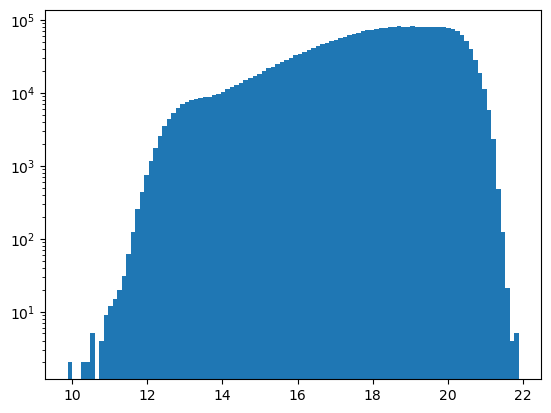

In [18]:
plt.hist(v_flux['vhs_m_ap_vista_ks'], bins=100)
plt.yscale('log')

In [19]:
np.sum(~np.isnan(v_flux['vhs_m_ap_vista_ks']))

3059275

In [20]:
import astropy.units as u

In [21]:
import astropy.units as u
for col in v_flux.colnames:
    if col.startswith('f'):
        v_flux[col] /= 1.E6
        v_flux[col].unit = u.Jansky


In [22]:
v_flux['vhs_ra'].unit = u.rad
v_flux['vhs_dec'].unit = u.rad
v_flux['vhs_ra'].convert_unit_to(u.rad)
v_flux['vhs_dec'].convert_unit_to(u.rad)
#v_flux['ra'].name = 'v_ra'
#v_flux['dec'].name = 'v_dec'

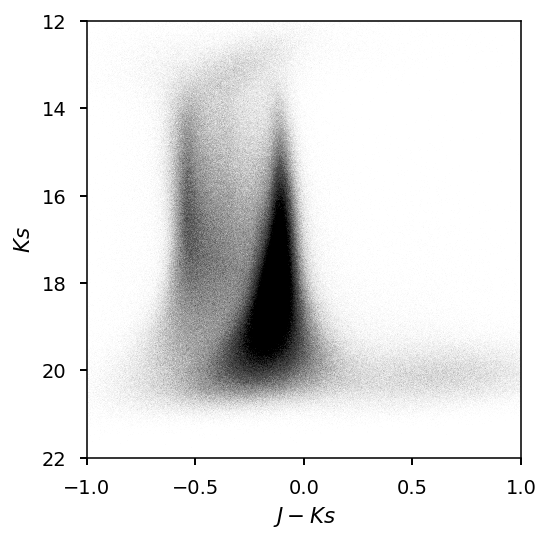

In [23]:

#selected = v_flux['f_vista_y'] / v_flux['ferr_vista_y'] > 5
#selected &= v_flux['f_vista_ks'] / v_flux['ferr_vista_ks'] > 5
plt.style.use('seaborn-notebook')
plt.figure(1, figsize=(4, 4), dpi=140)
plt.scatter(v_flux['vhs_m_ap_vista_j'] - v_flux['vhs_m_ap_vista_ks'],
            v_flux['vhs_m_ap_vista_ks'],
            edgecolors='None', s=0.005, c='k', rasterized=True)
plt.xlim(-1, 1)
plt.ylim(22, 12)
plt.xlabel('$J-Ks$')
plt.ylabel('$Ks$')
plt.subplots_adjust(left=0.125, bottom=0.1)
plt.show()

In [24]:
import logging
LOGGER = logging.getLogger(__name__)
from astropy.coordinates import SkyCoord, Angle
import astropy.units as u
from collections import Counter
from astropy.table import Table, Column, hstack, vstack
def merge_catalogues(cat_1, cat_2, racol_2, decol_2, radius=0.4*u.arcsec):
    """Merge two catalogues
    This function merges the second catalogue into the first one using the
    given radius to associate identical sources.  This function takes care to
    associate only one source of one catalogue to the other.  The sources that
    may be associated to various counterparts in the other catalogue are
    flagged as “maybe spurious association” with a true value in the
    flag_merged column.  If this column is present in the first catalogue, it's
    content is “inherited” during the merge.
    Parameters
    ----------
    cat_1: astropy.table.Table
        The table containing the first catalogue.  This is the master catalogue
        used during the merge.  If it has a “flag_merged” column it's content
        will be re-used in the flagging of the spurious merges.  This catalogue
        must contain a ‘ra’ and a ‘dec’ columns with the position in decimal
        degrees.
    cat_2: astropy.table.Table
        The table containing the second catalogue.
    racol_2: string
        Name of the column in the second table containing the right ascension
        in decimal degrees.
    decol_2: string
        Name of the column in the second table containing the declination in
        decimal degrees.
    radius: astropy.units.quantity.Quantity
        The radius to associate identical sources in the two catalogues.
    Returns
    -------
    astropy.table.Table
        The merged catalogue.
    """
    cat_1 = cat_1.copy()
    cat_2 = cat_2.copy()
    cat_1['ra'].unit = u.rad
    cat_1['dec'].unit = u.rad
    coords_1 = SkyCoord(cat_1['ra'], cat_1['dec'])

    
    cat_2[racol_2].unit = u.rad
    cat_2[decol_2].unit = u.rad
    coords_2 = SkyCoord(cat_2[racol_2], cat_2[decol_2])

    # Search for sources in second catalogue matching the sources in the first
    # one.
    idx_2, idx_1, d2d, _ = coords_1.search_around_sky(coords_2, radius)

    # We want to flag the possible mis-associations, i.e. the sources in each
    # catalogue that are associated to several sources in the other one, but
    # also all the sources that are associated to a problematic source in the
    # other catalogue (e.g. if two sources in the first catalogue are
    # associated to the same source in the second catalogue, they must be
    # flagged as potentially problematic).
    #
    # Search for duplicate associations
    toflag_idx_1 = np.unique([item for item, count in Counter(idx_1).items()
                              if count > 1])
    toflag_idx_2 = np.unique([item for item, count in Counter(idx_2).items()
                              if count > 1])
    # Flagging the sources associated to duplicates
    dup_associated_in_idx1 = np.in1d(idx_2, toflag_idx_2)
    dup_associated_in_idx2 = np.in1d(idx_1, toflag_idx_1)
    toflag_idx_1 = np.unique(np.concatenate(
        (toflag_idx_1, idx_1[dup_associated_in_idx1])
    ))
    toflag_idx_2 = np.unique(np.concatenate(
        (toflag_idx_2, idx_2[dup_associated_in_idx2])
    ))

    # Adding the flags to the catalogue.  In the second catalogue, the column
    # is named "flag_merged_2" and will be combined to the flag_merged column
    # one the merge is done.
    try:
        cat_1["flag_merged"] |= np.in1d(np.arange(len(cat_1), dtype=int),
                                        toflag_idx_1)
    except KeyError:
        cat_1.add_column(Column(
            data=np.in1d(np.arange(len(cat_1), dtype=int), toflag_idx_1),
            name="flag_merged"
        ))
    try:
        cat_2["flag_merged_2"] |= np.in1d(np.arange(len(cat_2), dtype=int), toflag_idx_2)
    except KeyError:
        cat_2.add_column(Column(
            data=np.in1d(np.arange(len(cat_2), dtype=int), toflag_idx_2),
            name="flag_merged_2"
        ))


    # Now that we have flagged the maybe spurious associations, we want to
    # associate each source of each catalogue to at most one source in the
    # other one.

    # We sort the indices by the distance to take the nearest counterparts in
    # the following steps.
    sort_idx = np.argsort(d2d)
    idx_1 = idx_1[sort_idx]
    idx_2 = idx_2[sort_idx]

    # These array will contain the indexes of the matching sources in both
    # catalogues.
    match_idx_1 = np.array([], dtype=int)
    match_idx_2 = np.array([], dtype=int)

    while len(idx_1) > 0:

        both_first_idx = np.sort(np.intersect1d(
            np.unique(idx_1, return_index=True)[1],
            np.unique(idx_2, return_index=True)[1],
        ))

        new_match_idx_1 = idx_1[both_first_idx]
        new_match_idx_2 = idx_2[both_first_idx]

        match_idx_1 = np.concatenate((match_idx_1, new_match_idx_1))
        match_idx_2 = np.concatenate((match_idx_2, new_match_idx_2))

        # We remove the matching sources in both catalogues.
        to_remove = (np.in1d(idx_1, new_match_idx_1) |
                     np.in1d(idx_2, new_match_idx_2))
        idx_1 = idx_1[~to_remove]
        idx_2 = idx_2[~to_remove]

    # Indices of un-associated object in both catalogues.
    unmatched_idx_1 = np.delete(np.arange(len(cat_1), dtype=int),match_idx_1)
    unmatched_idx_2 = np.delete(np.arange(len(cat_2), dtype=int),match_idx_2)

    # Sources only in cat_1
    only_in_cat_1 = cat_1[unmatched_idx_1]

    # Sources only in cat_2
    only_in_cat_2 = cat_2[unmatched_idx_2]
    # We are using the ra and dec columns from cat_2 for the position.
    only_in_cat_2[racol_2].name = "ra"
    only_in_cat_2[decol_2].name = "dec"

    # Merged table of sources in both catalogues.
    both_in_cat_1_and_cat_2 = hstack([cat_1[match_idx_1], cat_2[match_idx_2]])
    # We don't need the positions from the second catalogue anymore.
    both_in_cat_1_and_cat_2.remove_columns([racol_2, decol_2])

    # Logging the number of rows
    LOGGER.info("There are %s sources only in the first catalogue",
                len(only_in_cat_1))
    LOGGER.info("There are %s sources only in the second catalogue",
                len(only_in_cat_2))
    LOGGER.info("There are %s sources in both catalogues",
                len(both_in_cat_1_and_cat_2))

    merged_catalogue = vstack([only_in_cat_1, both_in_cat_1_and_cat_2,
                               only_in_cat_2])

    # When vertically stacking the catalogues, some values in the flag columns
    # are masked because they did not exist in the catalogue some row originate
    # from. We must set them to the appropriate value.
    for colname in merged_catalogue.colnames:
        if 'flag' in colname:
            merged_catalogue[colname][merged_catalogue[colname].mask] = False

    # We combined the flag_merged flags
    merged_catalogue['flag_merged'] |= merged_catalogue['flag_merged_2']
    merged_catalogue.remove_column('flag_merged_2')
    merged_catalogue.remove_column('flag_merged')
    return merged_catalogue

In [25]:
r_cat = Table.read(EX_CAT)

In [30]:
len(list(ps_refcats))

18836

In [ ]:
#VHS REF CAT
!mkdir -p data/ref_cats_vhs
n=0
for c in ps_refcats:
    #Only run if file is missing
    if exists('./data/ref_cats_vhs/{}.fits'.format(c)):
        continue
    r_cat = Table.read("../dmu0/dmu0_PanStarrs/data/ps1_pv3_3pi_20170110/{}.fits".format(c))
    r_cat['coord_ra'].name = 'ra'
    r_cat['coord_dec'].name = 'dec'
    merge = merge_catalogues(r_cat, v_flux, 'vhs_ra', 'vhs_dec', radius=0.4*u.arcsec)
    merge=clean_table(merge)
    has_both  = (
        (merge['g_flux'] >0.)
        # &(merge['vhs_m_ap_vista_ks']>0.) #Take all panstarrs objects
    )
    merge = merge[has_both]
    if np.sum(merge['vhs_m_ap_vista_ks']>0.) == 0:
        #print('No VHS Objects in ', c)
        continue
    n+=1
    merge['ra'].name = 'coord_ra'
    merge['dec'].name = 'coord_dec'
    #convert rad to degs?
    merge['coord_ra'] = (180./np.pi)*merge['coord_ra']
    merge['coord_ra'].unit = u.deg
    merge['coord_dec'] = (180./np.pi)*merge['coord_dec']
    merge['coord_dec'].unit = u.deg
    merge['pm_ra_err'].name = 'pm_raErr'
    merge['pm_dec_err'].name = 'pm_decErr'
    try:
        merge['coord_raErr'] = (180./np.pi)*merge['coord_ra_err']
        merge['coord_raErr'].unit = u.deg
        merge['coord_decErr'] = (180./np.pi)*merge['coord_dec_err']
        merge['coord_decErr'].unit = u.deg
        merge.remove_columns['coord_ra_err', 'coord_dec_err']
    except:
        merge['coord_raErr'] = (180./np.pi)*merge['coord_raErr']
        merge['coord_raErr'].unit = u.deg
        merge['coord_decErr'] = (180./np.pi)*merge['coord_decErr']
        merge['coord_decErr'].unit = u.deg
    #flags col only in James Mulaney 19 cut cat
    #merge['flags'].format = '1X'
    merge['epoch'] = merge['epoch'].astype('int32')
    #merge[has_both].write('./data/refcats/{}.fits'.format(c), overwrite=True)
    
    for col in merge.colnames:
        #go through every flux column and convert to mags and rename
        if col.endswith('_flux'):
            err_col = col + 'Sigma'
            mag = abMagFromFlux(merge[col])
            mag_err = abMagErrFromFluxErr(merge[err_col],merge[col])
            merge[col] = mag
            merge[col].name = col[:-5]
            merge[err_col] = mag_err
            merge[err_col].name = err_col.replace('fluxSigma','err')
        #Go through every vhs mag col and rename
        if col.startswith('vhs_m_'):
            merge[col].name =col.split('_')[-1]
            merge[col.replace('vhs_m_', 'vhs_merr_')].name =  col.split('_')[-1] + '_err'
    if len(merge) == 0:
        print('No Objects in ', c)
        continue
    merge.remove_columns(['vhs_stellarity', 'vhs_id'])
    merge.write('./data/ref_cats_vhs/{}.fits'.format(c), overwrite=True)
    ex=merge.copy()
    print("Shard {} has {} objects and {} VHS mags.".format(c, len(merge), np.sum(~np.isnan(merge['ks']))))
    del merge


In [ ]:
ex[:5]